<a href="https://colab.research.google.com/github/jaspersprakel/queueing_book/blob/master/notebooks/emas_case1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Notebook Assignment Data Science

**Introduction**

Over the past decade, platforms like Airbnb have transformed the way people travel, offering flexible and personalized alternatives to traditional hotel accommodations. With thousands of listings in major cities around the world, platforms like Airbnb not only facilitate short-term rentals but also generate a vast amount of user-generated data, including guest reviews. These reviews serve as a valuable source of insight, reflecting the quality of listings, guest satisfaction, and overall experiences.

In this project, the focus is on analyzing Airbnb listings in New York City with the goal of understanding the factors that influence a listing’s overall review score. The review score is a key indicator of listing quality and guest experience, and understanding what drives higher (or lower) scores can benefit both hosts and potential guests. For hosts, it offers guidance on how to improve their service and increase competitiveness; for guests, it helps in making informed booking decisions.

Using the Inside Airbnb dataset, a range of machine learning and statistical techniques are applied to explore which featuressuch as location, room type, host behavior, availability, and amenities are most predictive of review scores. Our analysis includes a combination of exploratory data analysis, data cleaning, feature engineering, and predictive modeling using methods such as logistic regression, decision trees, random forests, and XGBoost.

This analysis also aims to demonstrate how data science can be applied to real-world consumer platforms to extract meaningful insights from publicly available data. By identifying patterns in user behavior and listing characteristics, we provide a deeper understanding of what drives guest satisfaction in the sharing economy.

The remainder of this report covers the data preparation process, modeling approach, and evaluation of results, followed by a discussion of key takeaways, limitations, and suggestions for future work.

In [1]:
%%capture
!git clone https://github.com/ramonVDAKKER/teaching-data-science-emas
!pip install https://github.com/pandas-profiling/pandas-profiling/archive/master.zip
!jupyter nbextension enable --py widgetsnbextension
#test

**Import packages**

In [2]:
import os
print(os.getcwd())
os.chdir("teaching-data-science-emas/notebooks")

/content


Important packages for Python are <a href="http://www.numpy.org/">numpy</a> (for arrays, linear algebra, pseudorandom numbers etc.), <a href="http://pandas.pydata.org/">pandas</a> (contains convenient data structure called "pandas dataframe"), <a href="http://matplotlib.org/">matplotlib</a> & <a href="http://seaborn.pydata.org/"> seaborn</a> (for data visualisation), <a href="http://scikit-learn.org/stable/">sklearn</a> (scikit-learn; powerful package containing machine & statistical learning functions), and  <a href="https://www.statsmodels.org/stable/index.html">statsmodels</a> for statistical models and routines.

In [48]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from matplotlib import cm
from matplotlib import ticker as ticker
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
import statsmodels.api as sm
from sklearn.metrics import confusion_matrix,  accuracy_score, roc_auc_score, precision_recall_curve, RocCurveDisplay
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier
import seaborn as sns
import xgboost as xgb

In [4]:
%matplotlib inline

## 1. Load dataset & Elementary Data Analysis

### 1.1 Load and inspect data

Load dataset into a pandas dataframe:

In [5]:
from google.colab import files
uploaded = files.upload()
import io
import pandas as pd

dataset = pd.read_csv(io.BytesIO(uploaded['listings 2.csv']))

#dataset = pd.read_csv("./data/case_1/DataTrain.csv")

Saving listings 2.csv to listings 2.csv


<ipython-input-5-0dfb0f2eaabb>:6: DtypeWarning: Columns (67) have mixed types. Specify dtype option on import or set low_memory=False.
  dataset = pd.read_csv(io.BytesIO(uploaded['listings 2.csv']))


The dataset is first split into a "train set" and a "validation set".

In [6]:
seed = 123
train_df, aux_df = train_test_split(dataset, train_size=.5, random_state=seed)
validation_df, test_df = train_test_split(aux_df, train_size=.5, random_state=seed)

print(f"data_train shape: {train_df.shape}")
print(f"data_validation shape: {validation_df.shape}")
print(f"data_test shape: {test_df.shape}")
del dataset

data_train shape: (18705, 74)
data_validation shape: (9352, 74)
data_test shape: (9353, 74)


Let us inspect the first 3 and the last 3 rows of the dataset:

In [7]:
pd.options.display.max_columns = 100
display(train_df.head(3))
display(train_df.tail(3))

id                                      listing_url  \
8133             12686241            https://www.airbnb.com/rooms/12686241   
24373            45261941            https://www.airbnb.com/rooms/45261941   
35726  602777088581961008  https://www.airbnb.com/rooms/602777088581961008   

            scrape_id last_scraped  \
8133   20220603182654   2022-06-04   
24373  20220603182654   2022-06-03   
35726  20220603182654   2022-06-03   

                                                  name  \
8133     Large Front Facing Bedroom & Private Backyard   
24373  A+ Location Classic Studio Suite(2 Double Beds)   
35726                             Sweet SoHo 1 Bedroom   

                                             description  \
8133   Large bedroom on Garden floor with backyard ac...   
24373  Our apartment is located in the center of Manh...   
35726  (AC works!) The best location in NYC! Steps fr...   

                                   neighborhood_overview  \
8133                                                 NaN   
24373  This is a very central location where you can ...   
35726                                                NaN   

                                             picture_url    host_id  \
8133   https://a0.muscache.com/pictures/58451700-6447...   30848788   
24373  https://a0.muscache.com/pictures/d415db7b-95f0...  348619646   
35726  https://a0.muscache.com/pictures/miso/Hosting-...  236369220   

                                          host_url host_name  host_since  \
8133    https://www.airbnb.com/users/show/30848788     Jamie  2015-04-08   
24373  https://www.airbnb.com/users/show/348619646     Nomad  2020-06-03   
35726  https://www.airbnb.com/users/show/236369220    Andrea  2019-01-13   

                             host_location  \
8133   De Kalb, Mississippi, United States   
24373    New York, New York, United States   
35726    New York, New York, United States   

                                              host_about  host_response_time  \
8133                                                 NaN  within a few hours   
24373  We are delighted to accommodate you during you...      within an hour   
35726                                                NaN        within a day   

      host_response_rate host_acceptance_rate host_is_superhost  \
8133                 90%                  75%                 f   
24373               100%                  99%                 f   
35726                75%                  46%                 f   

                                      host_thumbnail_url  \
8133   https://a0.muscache.com/im/pictures/user/706a1...   
24373  https://a0.muscache.com/im/pictures/user/00285...   
35726  https://a0.muscache.com/im/pictures/user/bb833...   

                                        host_picture_url  host_neighbourhood  \
8133   https://a0.muscache.com/im/pictures/user/706a1...  Bedford-Stuyvesant   
24373  https://a0.muscache.com/im/pictures/user/00285...                 NaN   
35726  https://a0.muscache.com/im/pictures/user/bb833...                 NaN   

       host_listings_count  host_total_listings_count  host_verifications  \
8133                   2.0                        2.0  ['email', 'phone']   
24373                 55.0                       55.0  ['email', 'phone']   
35726                  0.0                        0.0  ['email', 'phone']   

      host_has_profile_pic host_identity_verified            neighbourhood  \
8133                     t                      t                      NaN   
24373                    t                      t  New York, United States   
35726                    t                      t                      NaN   

      neighbourhood_cleansed neighbourhood_group_cleansed  latitude  \
8133      Bedford-Stuyvesant                     Brooklyn  40.69462   
24373                Midtown                    Manhattan  40.74797   
35726                 Nolita                    Manhattan  40.72136   

       l

id                            listing_url       scrape_id  \
17730  32549155  https://www.airbnb.com/rooms/32549155  20220603182654   
28030  50152840  https://www.airbnb.com/rooms/50152840  20220603182654   
15725  28220182  https://www.airbnb.com/rooms/28220182  20220603182654   

      last_scraped                                            name  \
17730   2022-06-04                          BK Home Away From Home   
28030   2022-06-04  A lovely smart home in Williamsburg-Greenpoint   
15725   2022-06-04          New Charming 1 Bedroom Oasis Apartment   

                                             description  \
17730  Charming 2 bedroom apartment on top floor of w...   
28030  Stay in a sun-filled apartment with smart-home...   
15725  A Newly renovated fully furnished one bedroom ...   

                                   neighborhood_overview  \
17730  Home of Junior's Cheesecake, Coney Island, Bar...   
28030  North Brooklyn (Greenpoint/Williamsburg) – the...   
15725  The neighborhood is historic and surrounded by...   

                                             picture_url    host_id  \
17730  https://a0.muscache.com/pictures/85873401-13c6...  244596528   
28030  https://a0.muscache.com/pictures/22f41221-7b98...    6796668   
15725  https://a0.muscache.com/pictures/38fa5d92-4957...   35387196   

                                          host_url host_name  host_since  \
17730  https://www.airbnb.com/users/show/244596528  Mary Ann  2019-02-21   
28030    https://www.airbnb.com/users/show/6796668     Milan  2013-06-08   
15725   https://www.airbnb.com/users/show/35387196    Kizzie  2015-06-09   

                           host_location  \
17730  Brooklyn, New York, United States   
28030  New York, New York, United States   
15725  Brooklyn, New York, United States   

                                              host_about  host_response_time  \
17730  Born and raised in Brooklyn, New York.  Gradua...      within an hour   
28030  I’m a New York based design and branding profe...      within an hour   
15725                                                NaN  within a few hours   

      host_response_rate host_acceptance_rate host_is_superhost  \
17730               100%                 100%                 t   
28030               100%                 100%                 f   
15725                80%                  75%                 f   

                                      host_thumbnail_url  \
17730  https://a0.muscache.com/im/pictures/user/69486...   
28030  https://a0.muscache.com/im/pictures/user/9934d...   
15725  https://a0.muscache.com/im/pictures/user/93ed6...   

                                        host_picture_url  host_neighbourhood  \
17730  https://a0.muscache.com/im/pictures/user/69486...  Bedford-Stuyvesant   
28030  https://a0.muscache.com/im/pictures/user/9934d...        Williamsburg   
15725  https://a0.muscache.com/im/pictures/user/93ed6...       Crown Heights   

       host_listings_count  host_total_listings_count  \
17730                  1.0                        1.0   
28030                  1.0                        1.0   
15725                  2.0                        2.0   

                     host_verifications host_has_profile_pic  \
17730                ['email', 'phone']                    t   
28030                ['email', 'phone']                    t   
15725  ['email', 'phone', 'work_email']                    t   

      host_identity_verified                      neighbourhood  \
17730                      t  Brooklyn, New York, United States   
28030                      t  Brooklyn, New York, United States   
15725                      t  Brooklyn, New York, United States   

          neighbourhood_cleansed neighbourhood_group_cleansed  latitude  \
17730         Bedford-Stuyvesant                     Brooklyn  40.69002   
28030               Williamsburg                     Brooklyn  40.71941   
15725  Prospect-Lefferts Gardens                     B

Some meta-data:

In [8]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 18705 entries, 8133 to 15725
Data columns (total 74 columns):
 #   Column                                        Non-Null Count  Dtype  
---  ------                                        --------------  -----  
 0   id                                            18705 non-null  int64  
 1   listing_url                                   18705 non-null  object 
 2   scrape_id                                     18705 non-null  int64  
 3   last_scraped                                  18705 non-null  object 
 4   name                                          18699 non-null  object 
 5   description                                   18266 non-null  object 
 6   neighborhood_overview                         11155 non-null  object 
 7   picture_url                                   18705 non-null  object 
 8   host_id                                       18705 non-null  int64  
 9   host_url                                      18705 non-null  o

See link below for a description of the columns.

https://www.kaggle.com/datasets/dominoweir/inside-airbnb-nyc?select=listings+2.csv

## 1.1 Summary statistics

In [9]:
train_df.describe()

id     scrape_id       host_id  host_listings_count  \
count  1.870500e+04  1.870500e+04  1.870500e+04          18678.00000   
mean   6.036603e+16  2.022060e+13  1.229774e+08             61.88275   
std    1.797305e+17  1.902395e+00  1.372348e+08            393.59663   
min    2.595000e+03  2.022060e+13  2.438000e+03              0.00000   
25%    1.422859e+07  2.022060e+13  1.263910e+07              1.00000   
50%    3.439381e+07  2.022060e+13  5.435116e+07              1.00000   
75%    4.989833e+07  2.022060e+13  2.069725e+08              3.00000   
max    6.412414e+17  2.022060e+13  4.623937e+08           3404.00000   

       host_total_listings_count      latitude     longitude  accommodates  \
count                18678.00000  18705.000000  18705.000000  18705.000000   
mean                    61.88275     40.729352    -73.946139      2.886234   
std                    393.59663      0.058142      0.056978      1.934833   
min                      0.00000     40.508630    -74.266750      0.000000   
25%                      1.00000     40.688420    -73.983600      2.000000   
50%                      1.00000     40.724900    -73.953910      2.000000   
75%                      3.00000     40.763250    -73.926760      4.000000   
max                   3404.00000     40.928340    -73.704260     16.000000   

       bathrooms      bedrooms          beds  minimum_nights  maximum_nights  \
count        0.0  16891.000000  18258.000000    18705.000000    1.870500e+04   
mean         NaN      1.349239      1.628053       19.825982    1.689919e+03   
std          NaN      0.733566      1.145854       33.249508    1.462313e+05   
min          NaN      1.000000      1.000000        1.000000    1.000000e+00   
25%          NaN      1.000000      1.000000        2.000000    6.000000e+01   
50%          NaN      1.000000      1.000000       30.000000    3.650000e+02   
75%          NaN      1.000000      2.000000       30.000000    1.125000e+03   
max          NaN     15.000000     42.000000     1250.000000    2.000000e+07   

       minimum_minimum_nights  maximum_minimum_nights  minimum_maximum_nights  \
count            18698.000000            18698.000000            1.869800e+04   
mean                20.538293               27.511285            1.609759e+06   
std                 41.963464               79.123872            5.874166e+07   
min                  1.000000                1.000000            1.000000e+00   
25%                  2.000000                3.000000            3.600000e+02   
50%                 30.000000               30.000000            1.125000e+03   
75%                 30.000000               30.000000            1.125000e+03   
max               1250.000000             1250.000000            2.147484e+09   

       maximum_maximum_nights  minimum_nights_avg_ntm  maximum_nights_avg_ntm  \
count            1.869800e+04            18698.000000            1.869800e+04   
mean             3.447383e+06               26.956974            2.460680e+06   
std              8.595202e+07               77.234696            6.704375e+07   
min              1.000000e+00                1.000000            1.000000e+00   
25%              3.650000e+02                2.000000            3.650000e+02   
50%              1.125000e+03               30.000000            1.125000e+03   
75%              1.125000e+03               30.000000            1.125000e+03   
max              2.147484e+09             1250.000000            2.147484e+09   

       calendar_updated  availability_30  availability_60  availability_90  \
count               0.0     18705.000000     18705.000000     18705.000000   
mean                NaN         4.669607        12.763111        23.434162   
std                 NaN         8.177008        18.598467        29.536626   
min                 NaN         0.000000         0.000000         0.000000   
25%                 NaN         0.000000         0.000000         0.000000   
50%             

## 1.2 Cleansing

Check for missing values:

In [10]:
#train_df.isnull().sum()
train_df.isnull().sum()[train_df.isnull().sum() > 0]

name                               6
description                      439
neighborhood_overview           7550
host_name                         27
host_since                        27
host_location                     77
host_about                      8257
host_response_time              6687
host_response_rate              6687
host_acceptance_rate            5941
host_is_superhost                 27
host_thumbnail_url                27
host_picture_url                  27
host_neighbourhood              3703
host_listings_count               27
host_total_listings_count         27
host_verifications                27
host_has_profile_pic              27
host_identity_verified            27
neighbourhood                   7550
bathrooms                      18705
bathrooms_text                    37
bedrooms                        1814
beds                             447
minimum_minimum_nights             7
maximum_minimum_nights             7
minimum_maximum_nights             7
maximum_maximum_nights             7
minimum_nights_avg_ntm             7
maximum_nights_avg_ntm             7
calendar_updated               18705
first_review                    3928
last_review                     3928
review_scores_rating            3928
review_scores_accuracy          4181
review_scores_cleanliness       4174
review_scores_checkin           4184
review_scores_communication     4178
review_scores_location          4186
review_scores_value             4186
license                        18705
reviews_per_month               3928
dtype: int64

Inspect the variable *Pdays* (see description):

In [11]:
print(train_df.columns.tolist())

['id', 'listing_url', 'scrape_id', 'last_scraped', 'name', 'description', 'neighborhood_overview', 'picture_url', 'host_id', 'host_url', 'host_name', 'host_since', 'host_location', 'host_about', 'host_response_time', 'host_response_rate', 'host_acceptance_rate', 'host_is_superhost', 'host_thumbnail_url', 'host_picture_url', 'host_neighbourhood', 'host_listings_count', 'host_total_listings_count', 'host_verifications', 'host_has_profile_pic', 'host_identity_verified', 'neighbourhood', 'neighbourhood_cleansed', 'neighbourhood_group_cleansed', 'latitude', 'longitude', 'property_type', 'room_type', 'accommodates', 'bathrooms', 'bathrooms_text', 'bedrooms', 'beds', 'amenities', 'price', 'minimum_nights', 'maximum_nights', 'minimum_minimum_nights', 'maximum_minimum_nights', 'minimum_maximum_nights', 'maximum_maximum_nights', 'minimum_nights_avg_ntm', 'maximum_nights_avg_ntm', 'calendar_updated', 'has_availability', 'availability_30', 'availability_60', 'availability_90', 'availability_365', 

Removing some of the irrelevant columns:

In [12]:
columns_to_keep = ['id', 'host_id', 'host_since', 'host_location', 'host_response_time', 'host_response_rate', 'host_acceptance_rate', 'host_is_superhost', 'host_listings_count', 'host_verifications', 'host_has_profile_pic', 'host_identity_verified', 'neighbourhood_group_cleansed', 'latitude', 'longitude', 'property_type', 'room_type', 'accommodates', 'bathrooms_text', 'bedrooms', 'beds', 'amenities', 'price', 'minimum_nights_avg_ntm', 'maximum_nights_avg_ntm', 'has_availability', 'availability_30', 'availability_60', 'availability_90', 'availability_365', 'number_of_reviews', 'number_of_reviews_ltm', 'number_of_reviews_l30d', 'first_review', 'last_review', 'review_scores_rating', 'review_scores_accuracy', 'review_scores_cleanliness', 'review_scores_checkin', 'review_scores_communication', 'review_scores_location', 'review_scores_value', 'instant_bookable', 'calculated_host_listings_count', 'calculated_host_listings_count_entire_homes', 'calculated_host_listings_count_private_rooms', 'calculated_host_listings_count_shared_rooms', 'reviews_per_month']
train_df = train_df[columns_to_keep]
print(train_df.columns.tolist())
len(train_df.columns)

['id', 'host_id', 'host_since', 'host_location', 'host_response_time', 'host_response_rate', 'host_acceptance_rate', 'host_is_superhost', 'host_listings_count', 'host_verifications', 'host_has_profile_pic', 'host_identity_verified', 'neighbourhood_group_cleansed', 'latitude', 'longitude', 'property_type', 'room_type', 'accommodates', 'bathrooms_text', 'bedrooms', 'beds', 'amenities', 'price', 'minimum_nights_avg_ntm', 'maximum_nights_avg_ntm', 'has_availability', 'availability_30', 'availability_60', 'availability_90', 'availability_365', 'number_of_reviews', 'number_of_reviews_ltm', 'number_of_reviews_l30d', 'first_review', 'last_review', 'review_scores_rating', 'review_scores_accuracy', 'review_scores_cleanliness', 'review_scores_checkin', 'review_scores_communication', 'review_scores_location', 'review_scores_value', 'instant_bookable', 'calculated_host_listings_count', 'calculated_host_listings_count_entire_homes', 'calculated_host_listings_count_private_rooms', 'calculated_host_li

48

## 1.3 Univariate plots

Distribution target variable:

Recall, that we are interested in the review_scores_rating for a rental from AirBnB.
The distribution of the target in the train set:


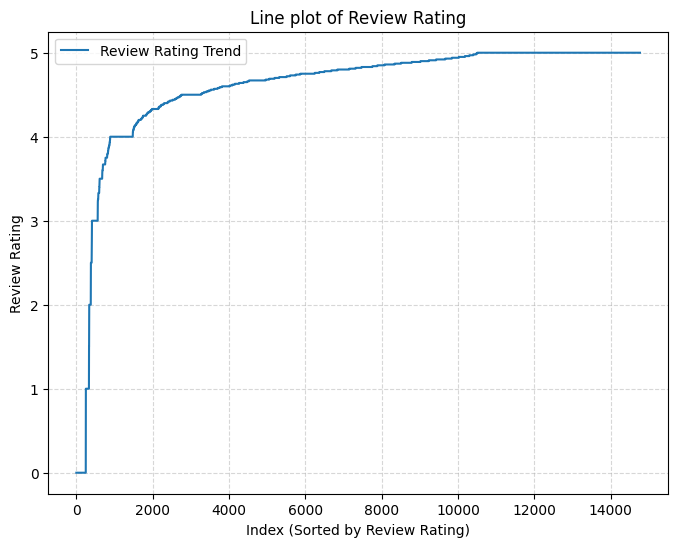

count    14770.000000
mean         4.605798
std          0.773620
min          0.000000
25%          4.570000
50%          4.820000
75%          5.000000
max          5.000000
Name: review_scores_rating, dtype: float64

In [28]:
print("Recall, that we are interested in the review_scores_rating for a rental from AirBnB.")
print("The distribution of the target in the train set:")
# Sort prices for a line plot
sorted_review_ratings = np.sort(train_df["review_scores_rating"].values)

# Create a line plot
plt.figure(figsize=(8, 6), facecolor="white")
plt.plot(sorted_review_ratings, label="Review Rating Trend")
plt.xlabel("Index (Sorted by Review Rating)")
plt.ylabel("Review Rating")
plt.title("Line plot of Review Rating")
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()

train_df["review_scores_rating"].describe()

In [29]:
print(f"The data type of the prices is {type(train_df['review_scores_rating'].loc[0])}\n")
print("This is because the prices include a $ sign. Therefore we should remove these and convert the data to numerical.")
train_df["price"] = train_df["price"].str.replace("$", "").str.replace(",", "").astype(float)
print(f"The data type of the target is now {type(train_df['price'].loc[0])}\n")
train_df["review_scores_rating"].describe()

print(f"From the description table, we find that there are some rentals with a price of 0, namely {(train_df['price'] == 0).sum()}.")
print(f"Looking closer at these {(train_df['price'] == 0).sum()} observations, we find that they have quite some missing data as well as no availability for the coming 365 days.")
print("As the price of 0 does not seem reasonable, these observations are excluded from the analysis as they will not provide any helpful insights.")

train_df[train_df["price"] == 0]

The data type of the prices is <class 'numpy.float64'>

This is because the prices include a $ sign. Therefore we should remove these and convert the data to numerical.


AttributeError: Can only use .str accessor with string values!

In [30]:
train_df = train_df[train_df['price'] != 0]
date_var = ['host_since', 'first_review', 'last_review']

The host_response_rate and the host_acceptance_rate show a special character, making them non numeric. Therefore a similar transformation to the price variable should be performed to make them numeric, to apply them in further analysis.

In [31]:
train_df["host_response_rate"] = train_df["host_response_rate"].str.replace("%", "").astype(float)
train_df["host_acceptance_rate"] = train_df["host_acceptance_rate"].str.replace("%", "").astype(float)

AttributeError: Can only use .str accessor with string values!

In [33]:
num_var = ['review_scores_rating', 'host_response_rate', 'host_acceptance_rate', 'host_listings_count', 'latitude', 'longitude', 'accommodates', 'bedrooms', 'beds', 'price', 'minimum_nights_avg_ntm', 'maximum_nights_avg_ntm', 'availability_30', 'availability_60', 'availability_90', 'availability_365', 'number_of_reviews', 'number_of_reviews_ltm', 'number_of_reviews_l30d', 'review_scores_accuracy', 'review_scores_cleanliness', 'review_scores_checkin', 'review_scores_communication', 'review_scores_location', 'review_scores_value', 'calculated_host_listings_count', 'calculated_host_listings_count_entire_homes', 'calculated_host_listings_count_private_rooms', 'calculated_host_listings_count_shared_rooms', 'reviews_per_month']
cat_var = ['host_location', 'host_response_time', 'host_is_superhost', 'host_verifications', 'host_has_profile_pic', 'host_identity_verified', 'neighbourhood_group_cleansed', 'property_type', 'room_type', 'bathrooms_text', 'has_availability', 'instant_bookable']

Histograms for numerical variables:

array([[<Axes: title={'center': 'review_scores_rating'}>,
        <Axes: title={'center': 'host_response_rate'}>,
        <Axes: title={'center': 'host_acceptance_rate'}>,
        <Axes: title={'center': 'host_listings_count'}>,
        <Axes: title={'center': 'latitude'}>],
       [<Axes: title={'center': 'longitude'}>,
        <Axes: title={'center': 'accommodates'}>,
        <Axes: title={'center': 'bedrooms'}>,
        <Axes: title={'center': 'beds'}>,
        <Axes: title={'center': 'price'}>],
       [<Axes: title={'center': 'minimum_nights_avg_ntm'}>,
        <Axes: title={'center': 'maximum_nights_avg_ntm'}>,
        <Axes: title={'center': 'availability_30'}>,
        <Axes: title={'center': 'availability_60'}>,
        <Axes: title={'center': 'availability_90'}>],
       [<Axes: title={'center': 'availability_365'}>,
        <Axes: title={'center': 'number_of_reviews'}>,
        <Axes: title={'center': 'number_of_reviews_ltm'}>,
        <Axes: title={'center': 'number_of_revi

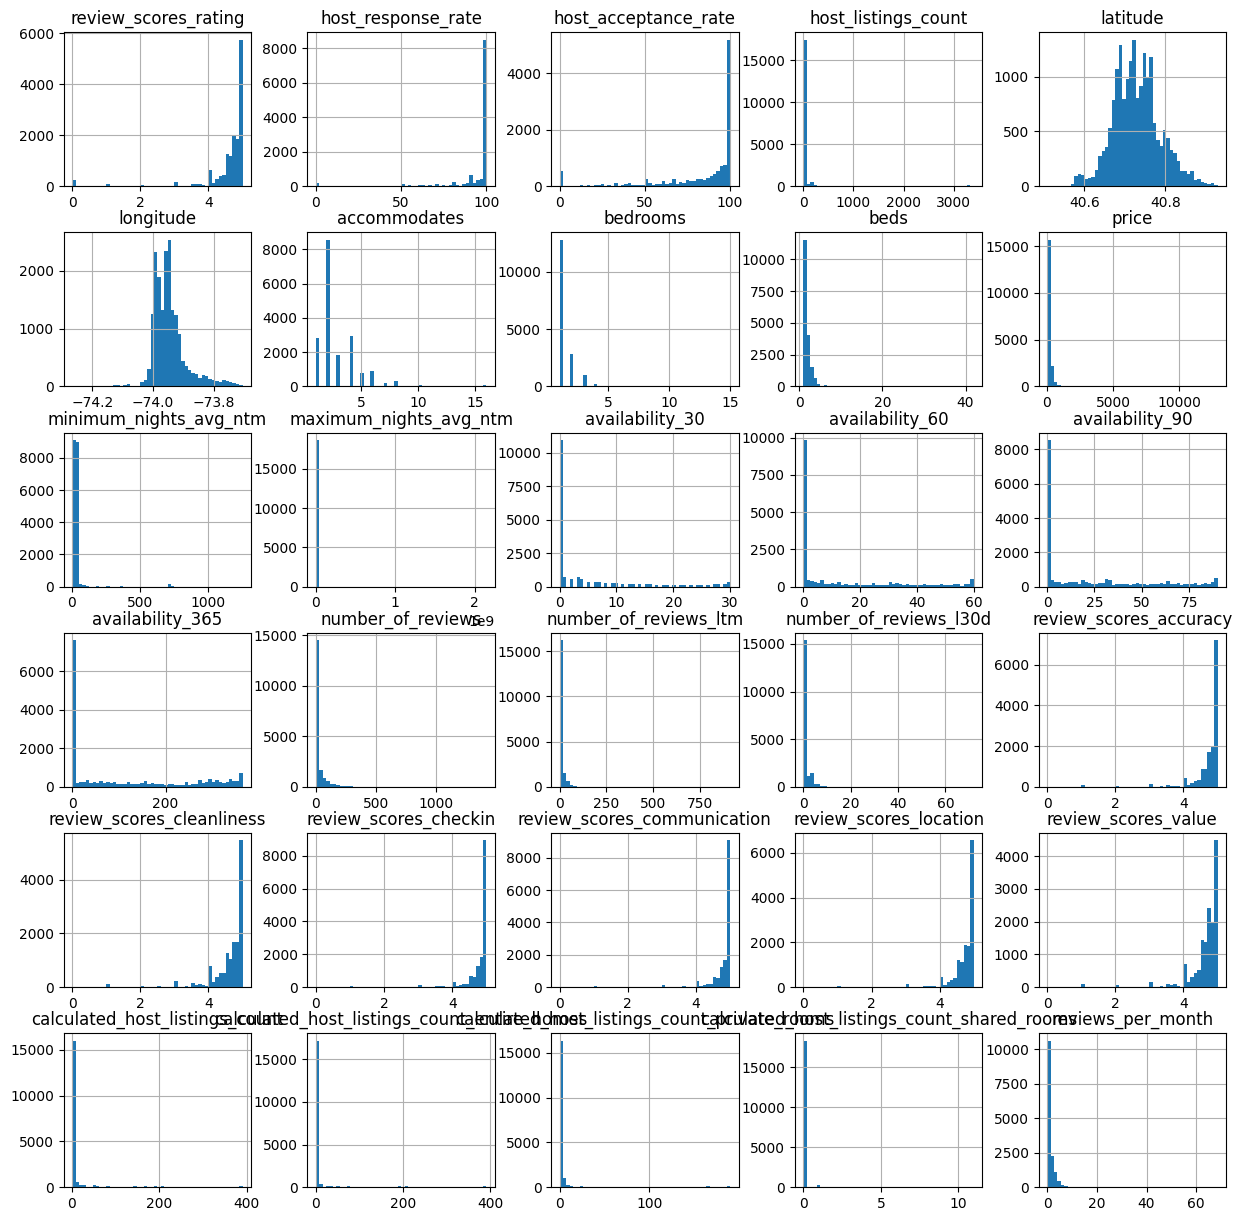

In [34]:
train_df[num_var].hist(bins=50, figsize=(15, 15))

Bar plots for categorical variables:

/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 20303 (\N{CJK UNIFIED IDEOGRAPH-4F4F}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 36807 (\N{CJK UNIFIED IDEOGRAPH-8FC7}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 33521 (\N{CJK UNIFIED IDEOGRAPH-82F1}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 22269 (\N{CJK UNIFIED IDEOGRAPH-56FD}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 20262 (\N{CJK UNIFIED IDEOGRAPH-4F26}) missing from font(s) DejaVu Sans.
  fig.canvas

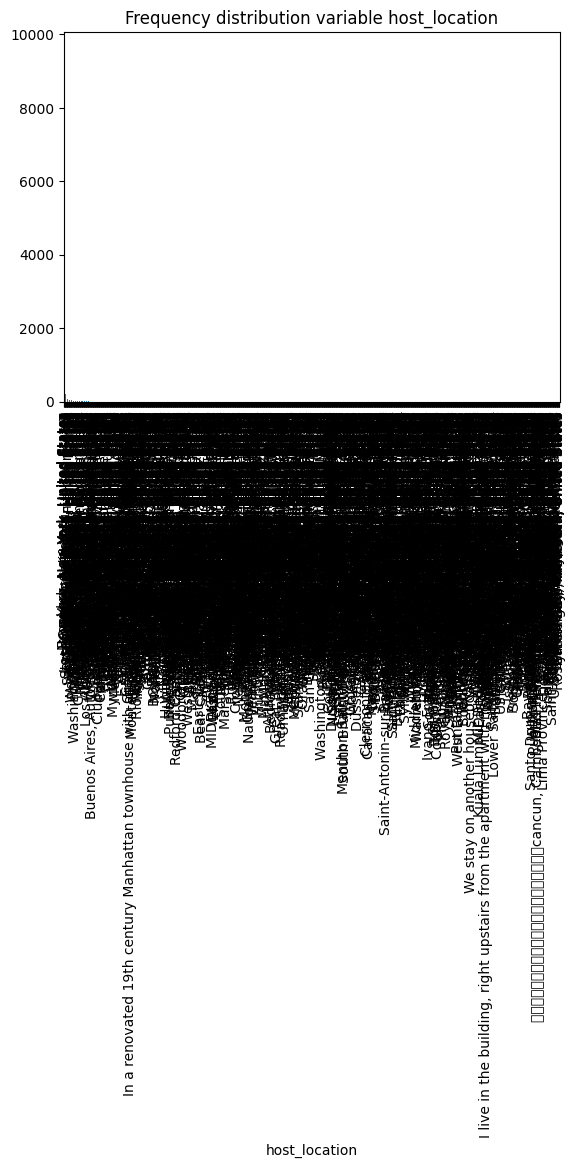

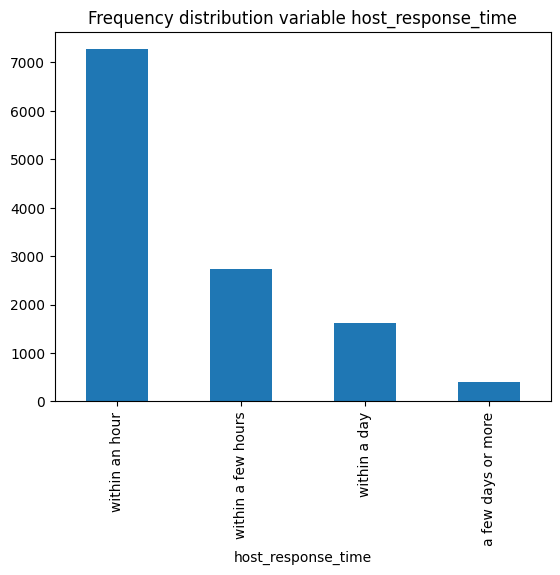

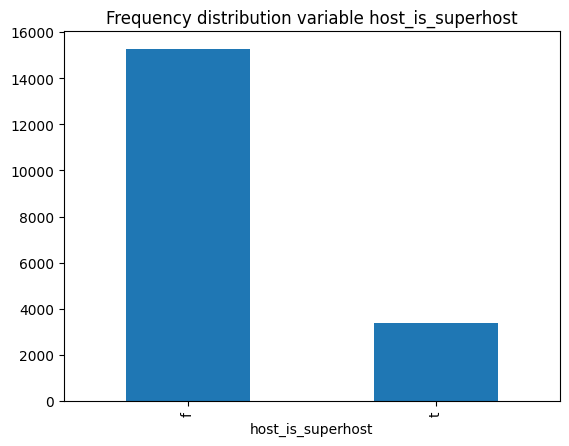

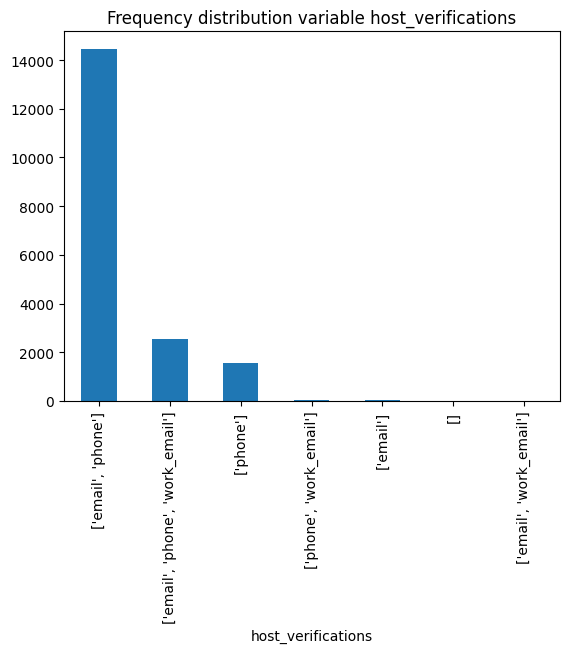

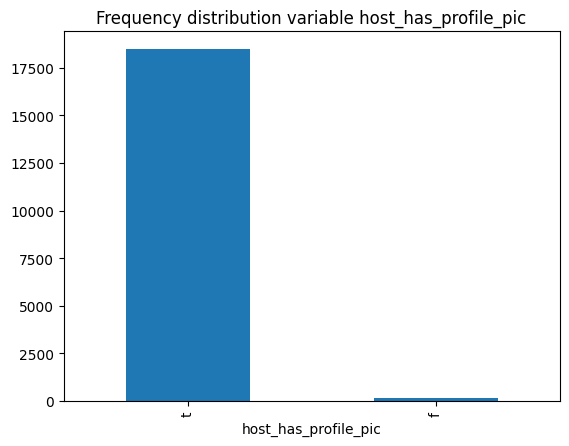

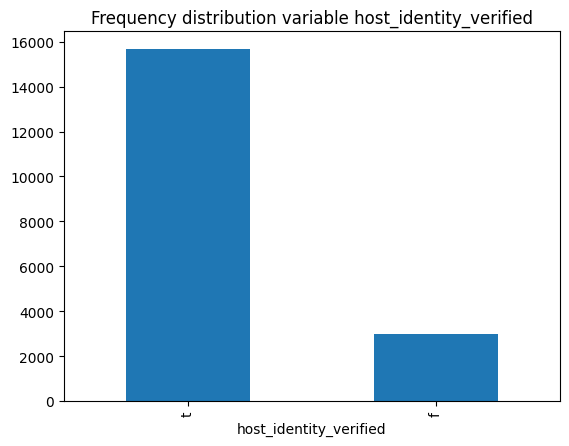

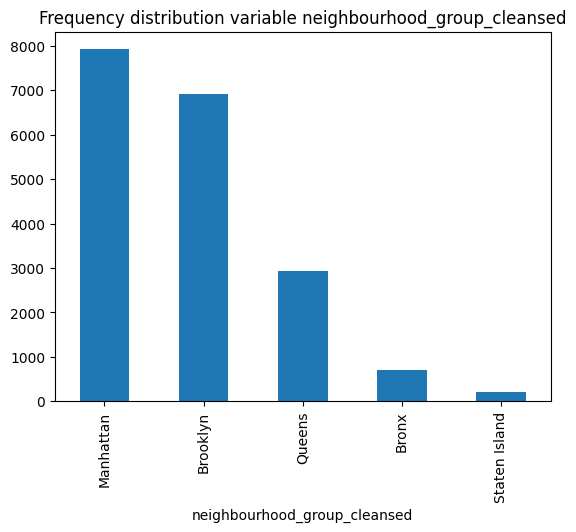

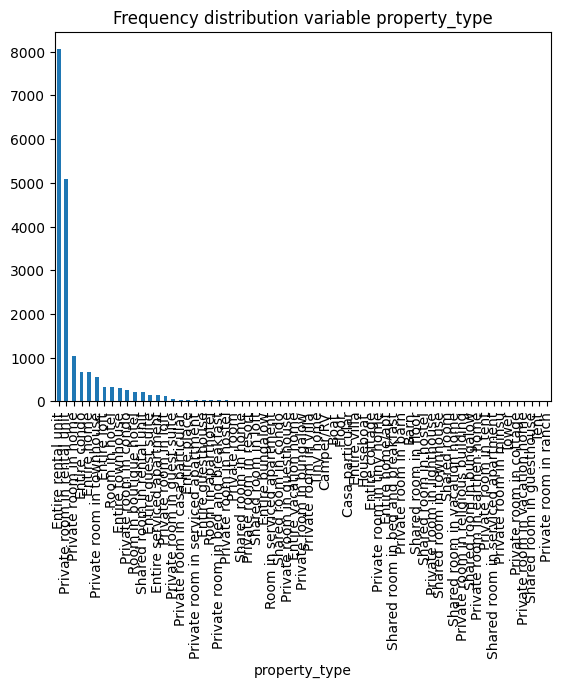

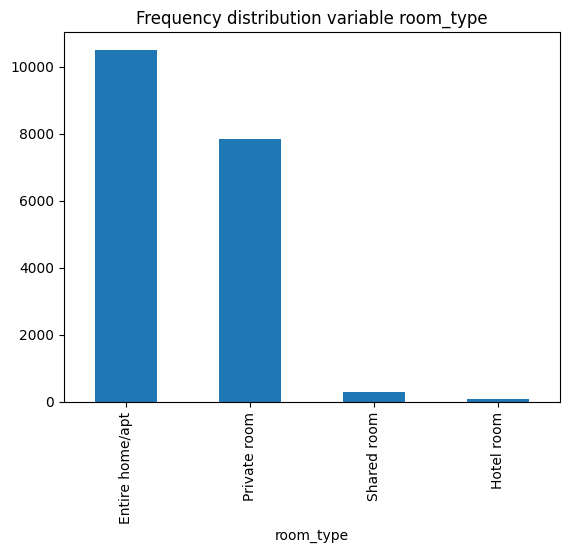

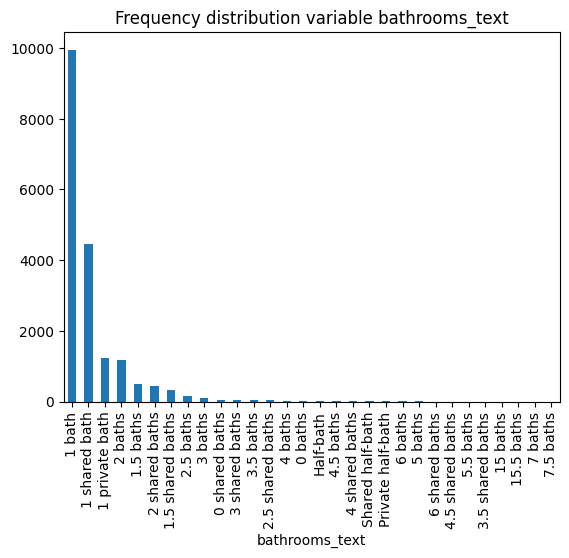

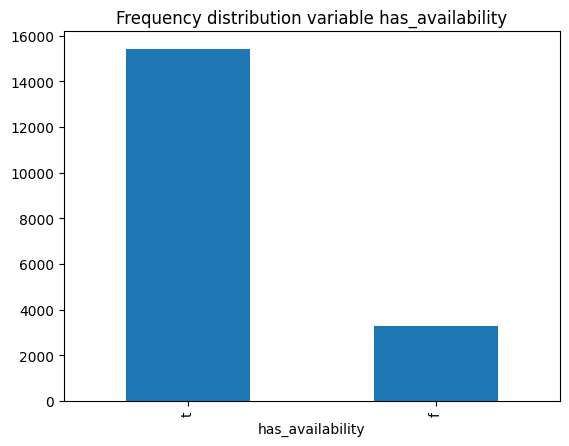

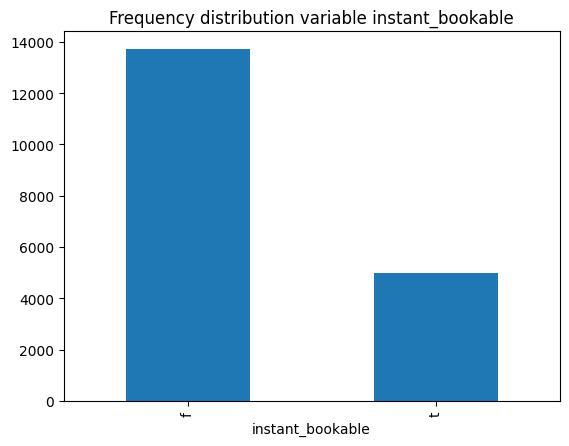

In [35]:
for var in cat_var:
    train_df[var].value_counts().plot(kind="bar", title=f"Frequency distribution variable {var}")
    plt.show()

### 1.4 Bivariate plots

Correlation between variables:

In [36]:
train_df[num_var].corr(method="pearson")

review_scores_rating  \
review_scores_rating                                      1.000000   
host_response_rate                                        0.106215   
host_acceptance_rate                                      0.039546   
host_listings_count                                      -0.013754   
latitude                                                 -0.045547   
longitude                                                 0.009887   
accommodates                                              0.028731   
bedrooms                                                  0.021707   
beds                                                      0.024613   
price                                                     0.028364   
minimum_nights_avg_ntm                                   -0.048270   
maximum_nights_avg_ntm                                   -0.000865   
availability_30                                           0.009642   
availability_60                                           0.029000   
availability_90                                           0.043658   
availability_365                                          0.058722   
number_of_reviews                                         0.101573   
number_of_reviews_ltm                                     0.082082   
number_of_reviews_l30d                                    0.091650   
review_scores_accuracy                                    0.827404   
review_scores_cleanliness                                 0.772233   
review_scores_checkin                                     0.698175   
review_scores_communication                               0.745192   
review_scores_location                                    0.592273   
review_scores_value                                       0.831304   
calculated_host_listings_count                           -0.033273   
calculated_host_listings_count_entire_homes               0.006424   
calculated_host_listings_count_private_rooms             -0.069794   
calculated_host_listings_count_shared_rooms              -0.035927   
reviews_per_month                                         0.101169   

                                              host_response_rate  \
review_scores_rating                                    0.106215   
host_response_rate                                      1.000000   
host_acceptance_rate                                    0.474046   
host_listings_count                                     0.064751   
latitude                                               -0.023790   
longitude                                               0.054282   
accommodates                                            0.043701   
bedrooms                                                0.020372   
beds                                                    0.050376   
price                                                  -0.033441   
minimum_nights_avg_ntm                                  0.019388   
maximum_nights_avg_ntm                                 -0.001795   
availability_30                                        -0.042634   
availability_60                                        -0.013413   
availability_90                                        -0.018891   
availability_365                                       -0.028482   
number_of_reviews                                       0.089394   
number_of_reviews_ltm                                   0.126473   
number_of_reviews_l30d                                  0.159010   
review_scores_accuracy                                  0.063955   
review_scores_cleanliness                               0.085977   
review_scores_checkin                                   0.067511   
review_scores_communication                             0.093938   
review_scores_location                                  0.029170   
review_scores_value                                     0.078158   
calculated_host_listings_count                          0.038448   
calculated_host_listings_count_entire_h

<ipython-input-37-0f4783709a0e>:4: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap("jet", 30)


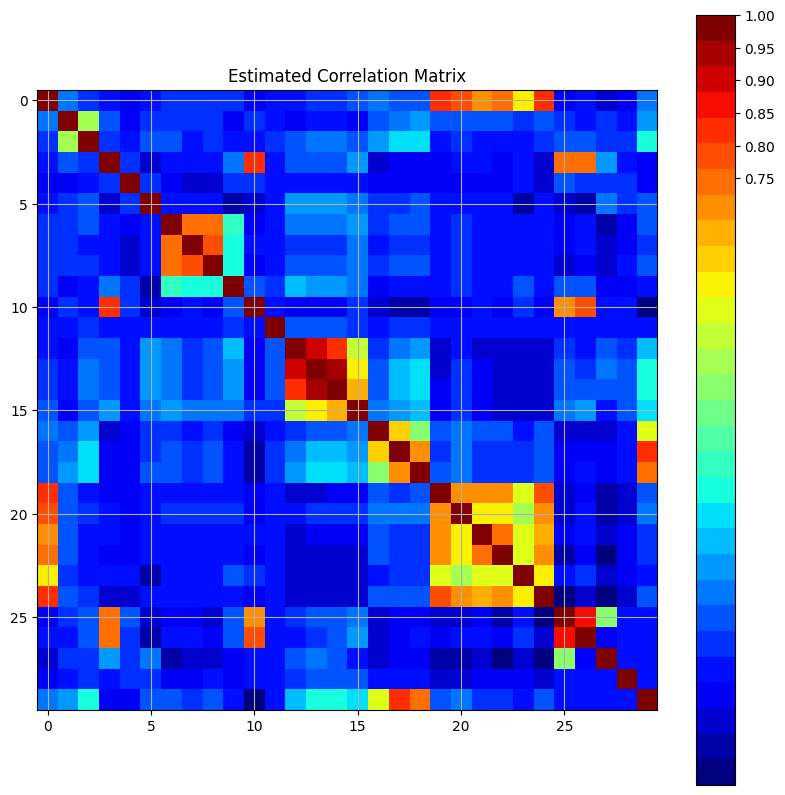

                                    Name feature
0                           review_scores_rating
1                             host_response_rate
2                           host_acceptance_rate
3                            host_listings_count
4                                       latitude
5                                      longitude
6                                   accommodates
7                                       bedrooms
8                                           beds
9                                          price
10                        minimum_nights_avg_ntm
11                        maximum_nights_avg_ntm
12                               availability_30
13                               availability_60
14                               availability_90
15                              availability_365
16                             number_of_reviews
17                         number_of_reviews_ltm
18                        number_of_reviews_l30d
19                  

In [37]:
def VizCorrelationMatrix(df):
    fig = plt.figure(figsize=(10, 10))
    ax1 = fig.add_subplot(111)
    cmap = cm.get_cmap("jet", 30)
    cax = ax1.imshow(df.corr(), interpolation="nearest", cmap=cmap)
    ax1.grid(True)
    plt.title("Estimated Correlation Matrix")
    fig.colorbar(cax, ticks=[.75, .8, .85, .90, .95, 1])
    plt.show()
VizCorrelationMatrix(train_df[num_var])
print(pd.DataFrame(num_var, columns=["Name feature"]))

Plots of the relation between price and numerical variable X:

Consider feature host_response_rate:


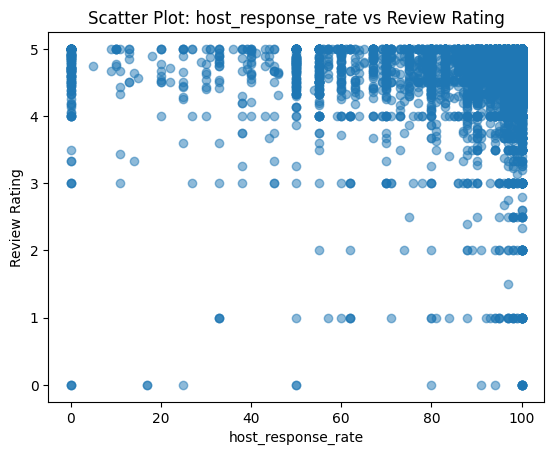

Consider feature host_acceptance_rate:


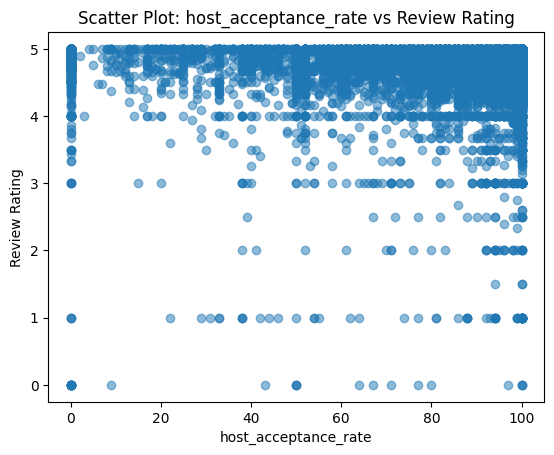

Consider feature host_listings_count:


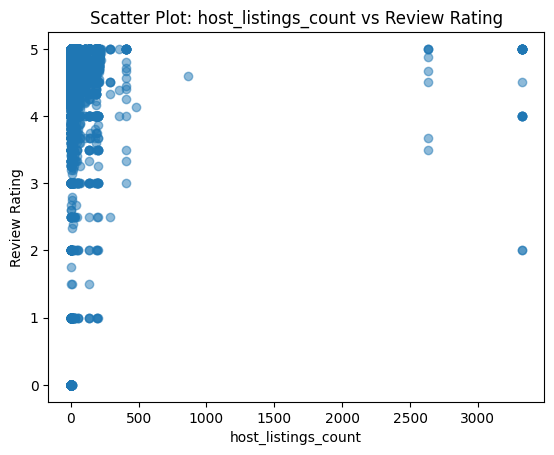

Consider feature latitude:


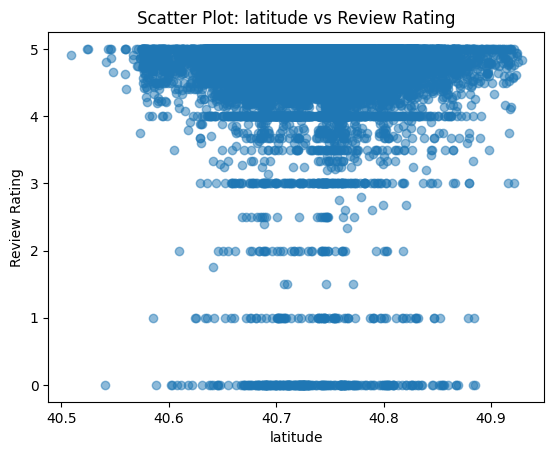

Consider feature longitude:


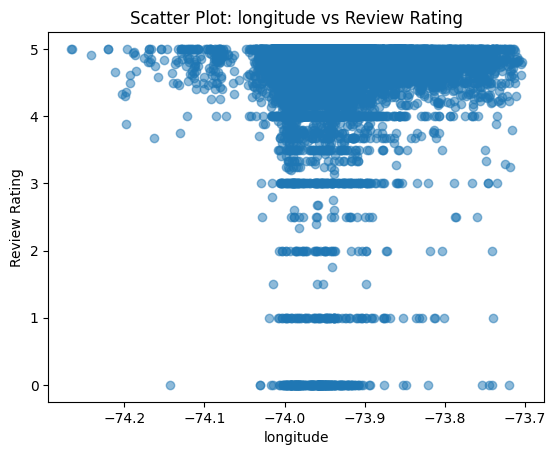

Consider feature accommodates:


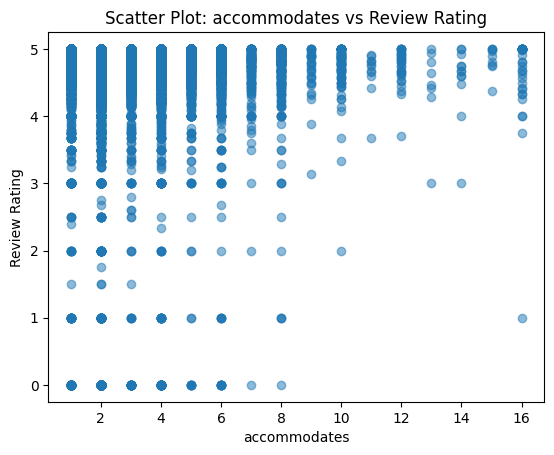

Consider feature bedrooms:


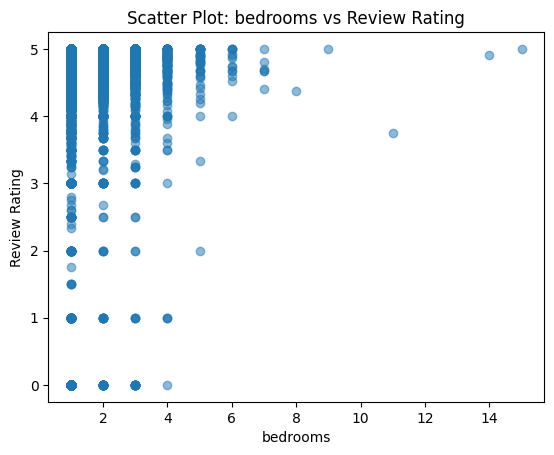

Consider feature beds:


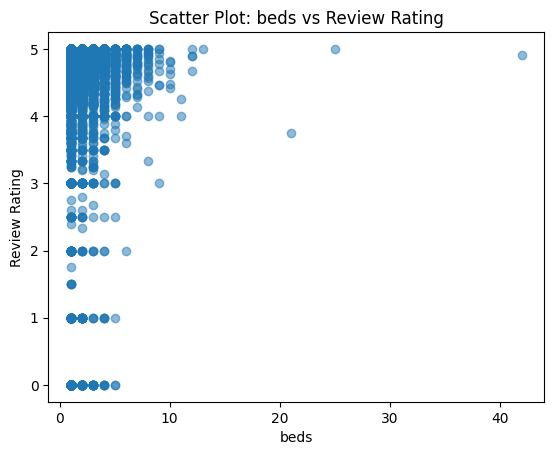

Consider feature price:


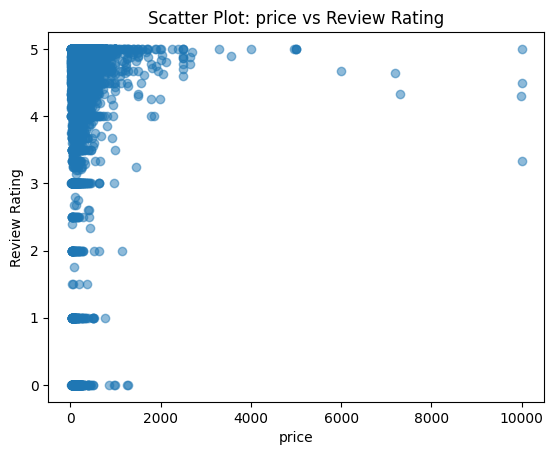

Consider feature minimum_nights_avg_ntm:


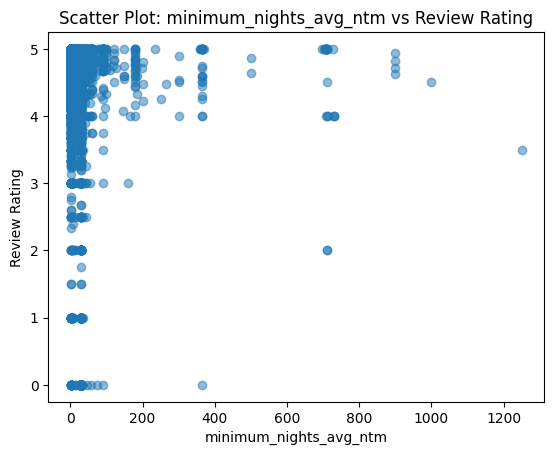

Consider feature maximum_nights_avg_ntm:


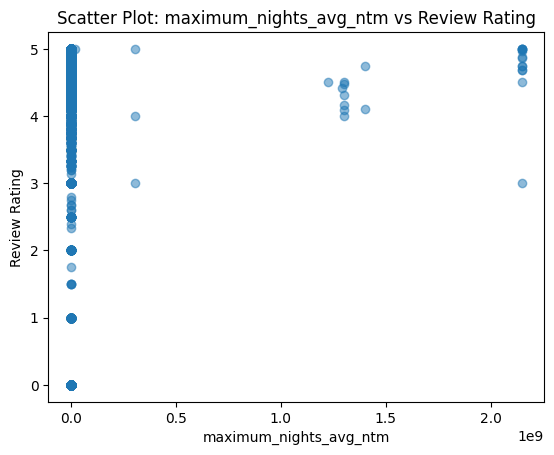

Consider feature availability_30:


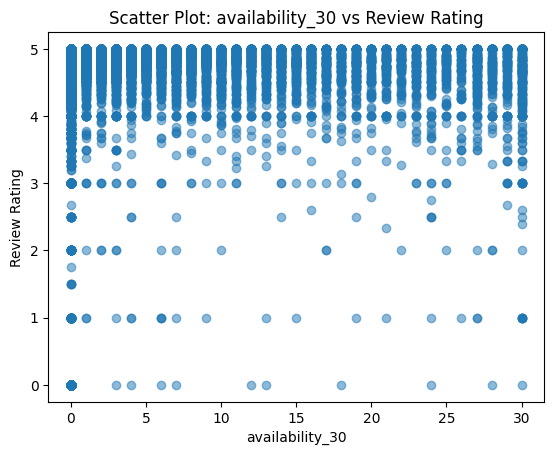

Consider feature availability_60:


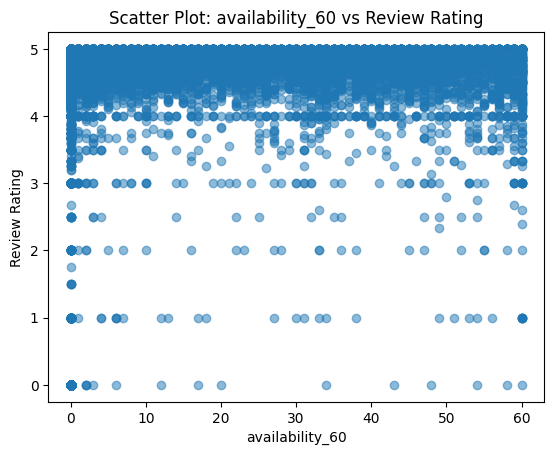

Consider feature availability_90:


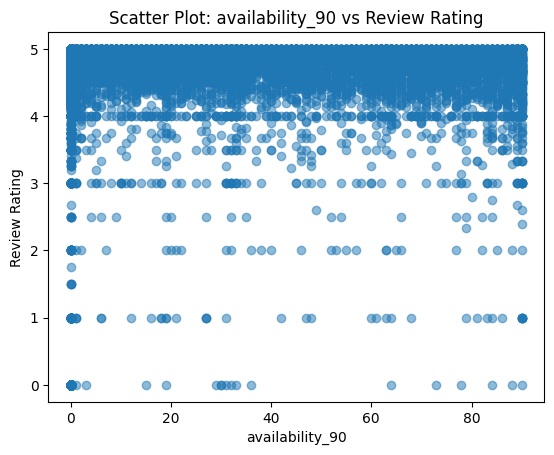

Consider feature availability_365:


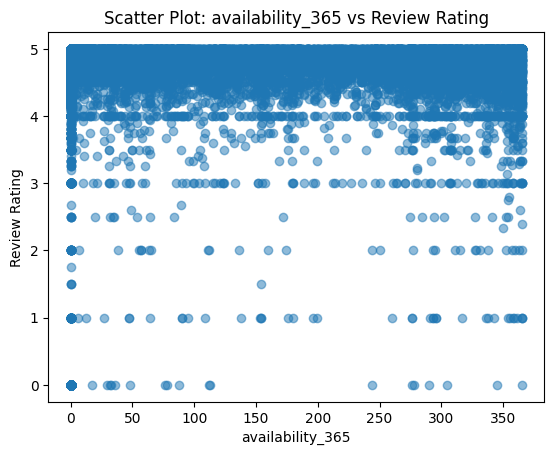

Consider feature number_of_reviews:


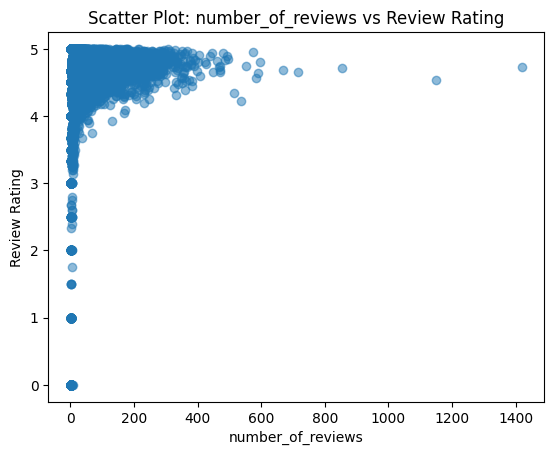

Consider feature number_of_reviews_ltm:


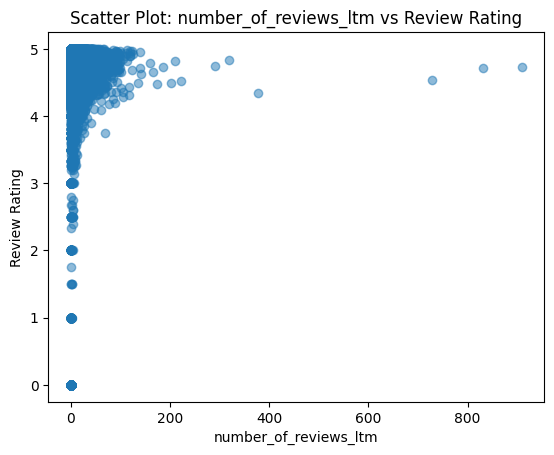

Consider feature number_of_reviews_l30d:


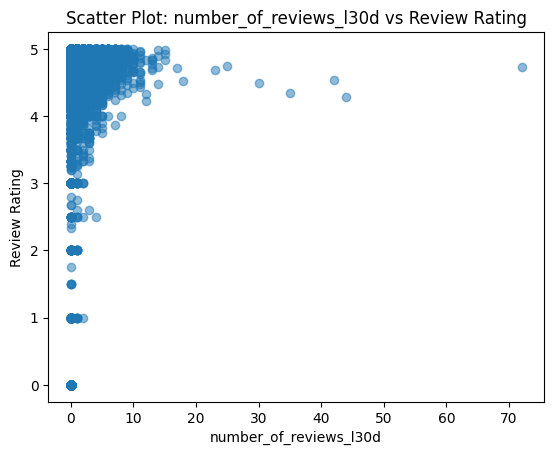

Consider feature review_scores_accuracy:


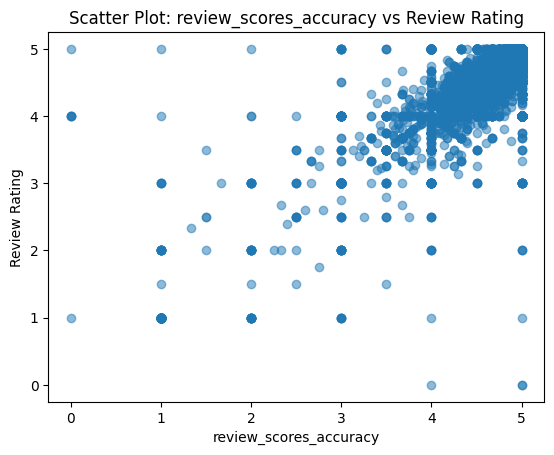

Consider feature review_scores_cleanliness:


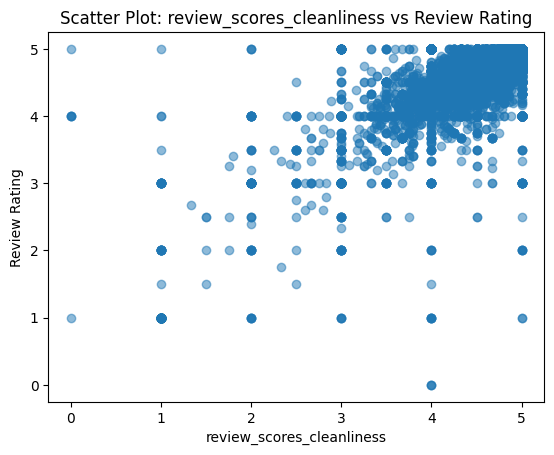

Consider feature review_scores_checkin:


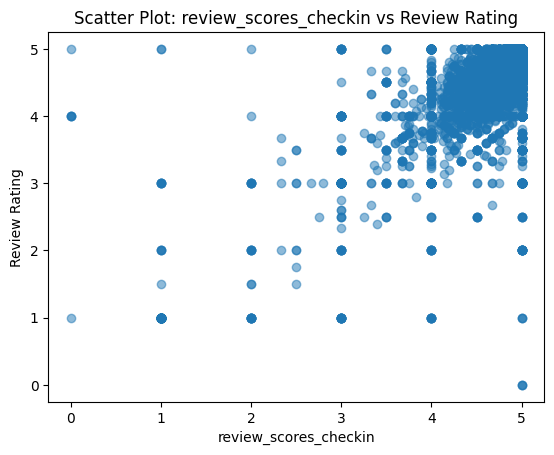

Consider feature review_scores_communication:


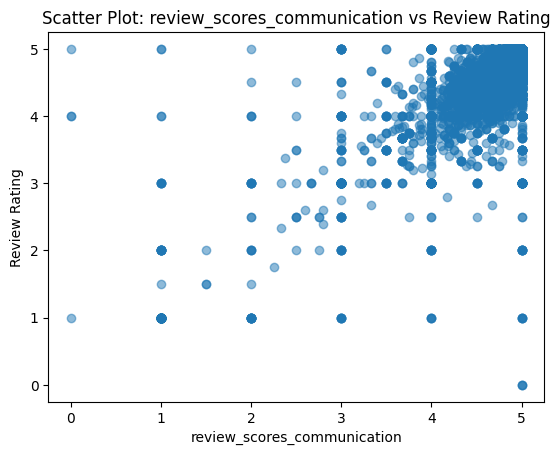

Consider feature review_scores_location:


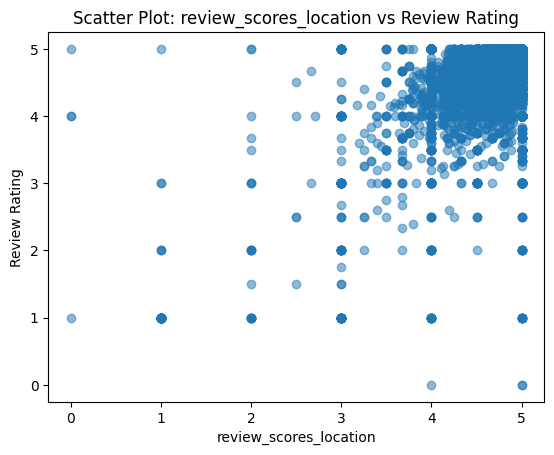

Consider feature review_scores_value:


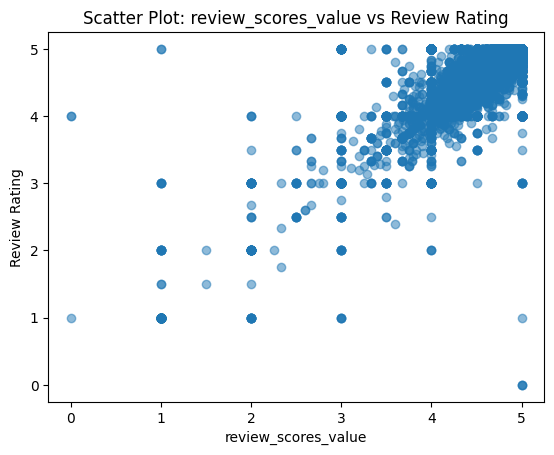

Consider feature calculated_host_listings_count:


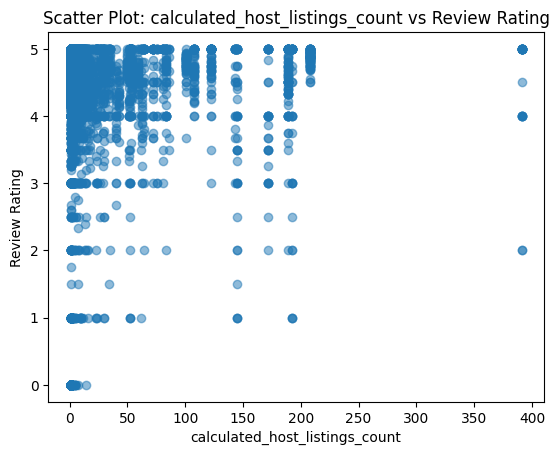

Consider feature calculated_host_listings_count_entire_homes:


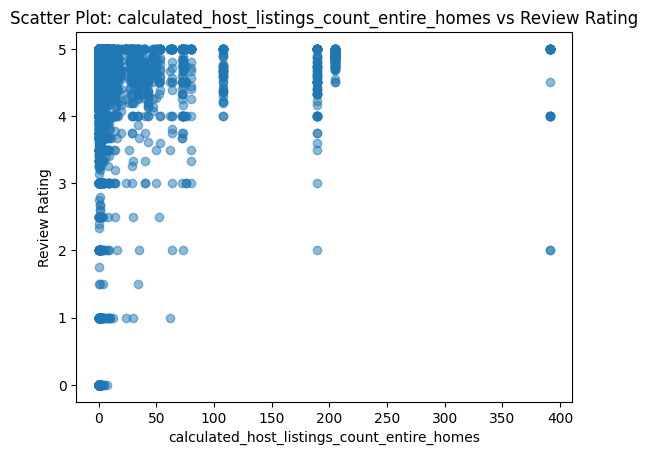

Consider feature calculated_host_listings_count_private_rooms:


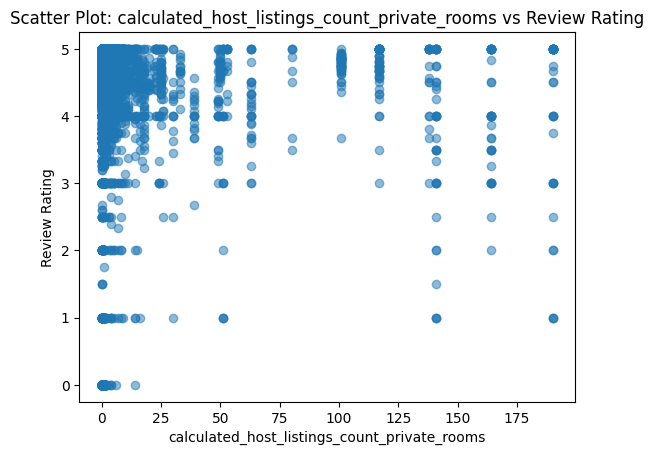

Consider feature calculated_host_listings_count_shared_rooms:


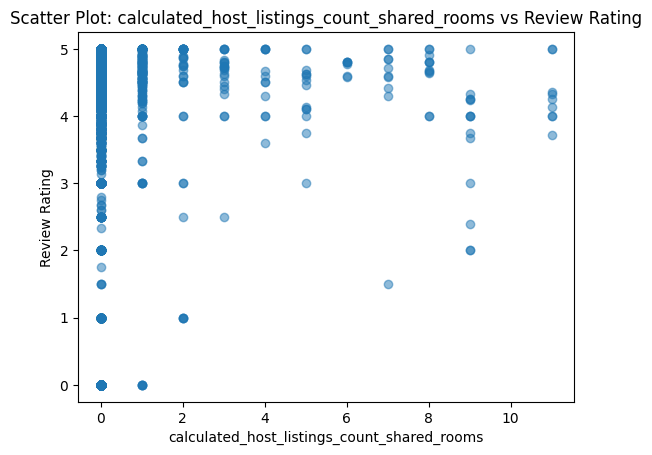

Consider feature reviews_per_month:


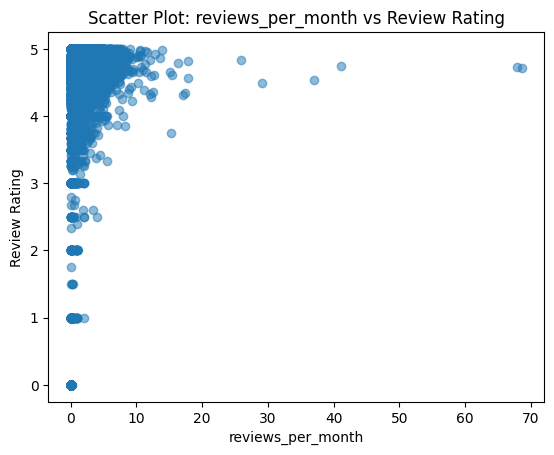

In [38]:
plot_var = ['host_response_rate', 'host_acceptance_rate', 'host_listings_count', 'latitude', 'longitude', 'accommodates', 'bedrooms', 'beds', 'price', 'minimum_nights_avg_ntm', 'maximum_nights_avg_ntm', 'availability_30', 'availability_60', 'availability_90', 'availability_365', 'number_of_reviews', 'number_of_reviews_ltm', 'number_of_reviews_l30d', 'review_scores_accuracy', 'review_scores_cleanliness', 'review_scores_checkin', 'review_scores_communication', 'review_scores_location', 'review_scores_value', 'calculated_host_listings_count', 'calculated_host_listings_count_entire_homes', 'calculated_host_listings_count_private_rooms', 'calculated_host_listings_count_shared_rooms', 'reviews_per_month']

Z = train_df.copy()
for name in plot_var:
    print("Consider feature " + name + ":")
    plt.scatter(Z[name], Z["review_scores_rating"], alpha=0.5)
    plt.xlabel(name)
    plt.ylabel("Review Rating")
    plt.title(f"Scatter Plot: {name} vs Review Rating")
    plt.show()

Box plot between the price and the categorical variables:

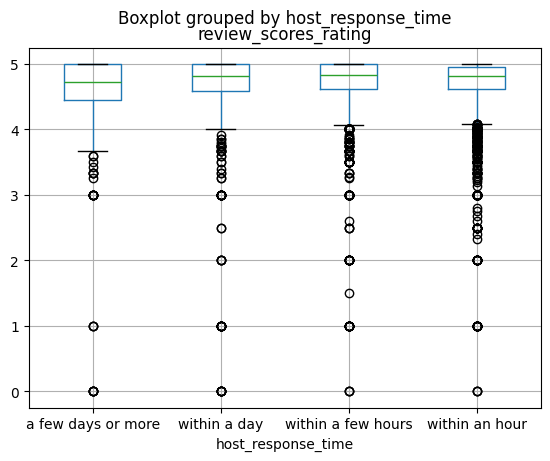

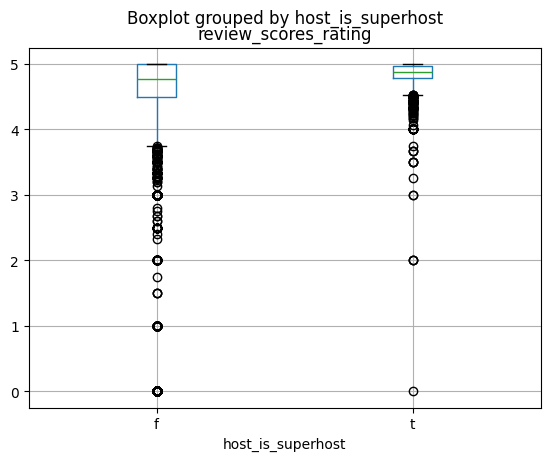

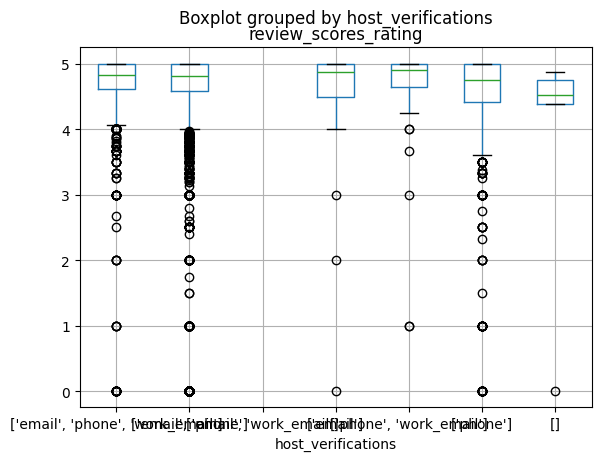

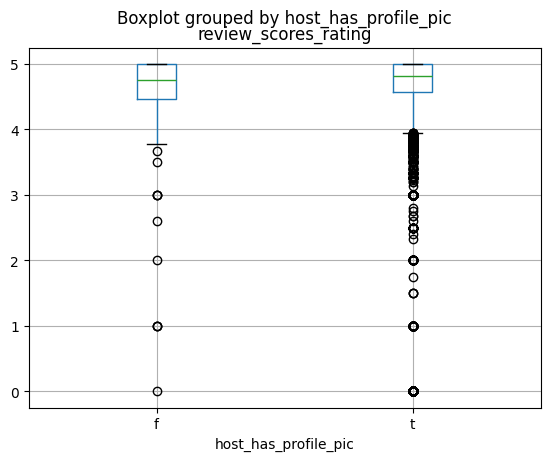

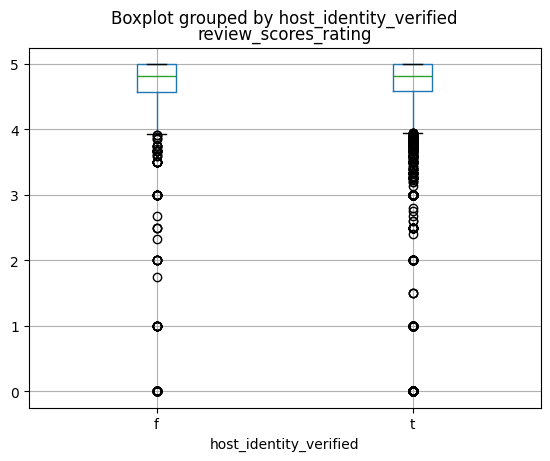

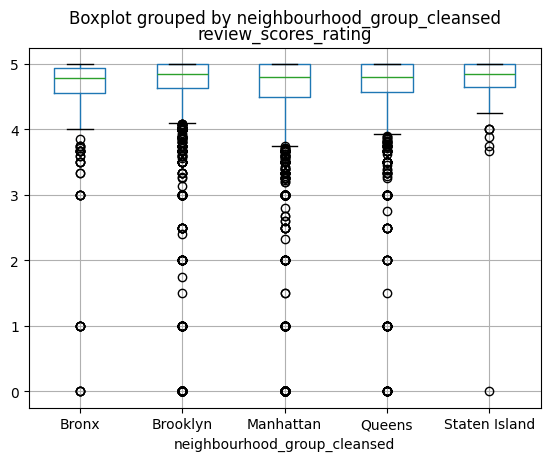

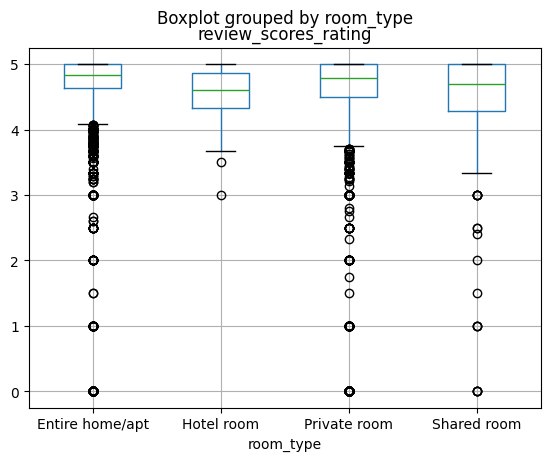

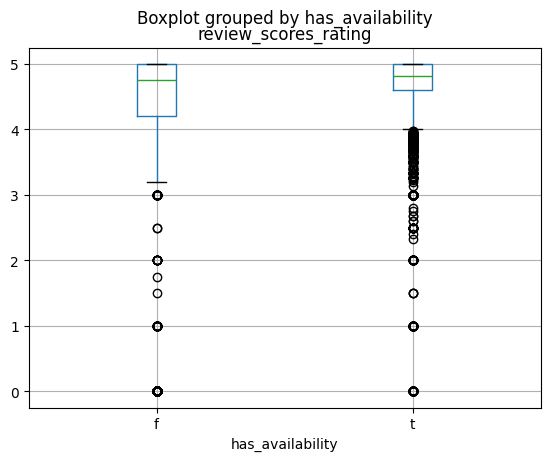

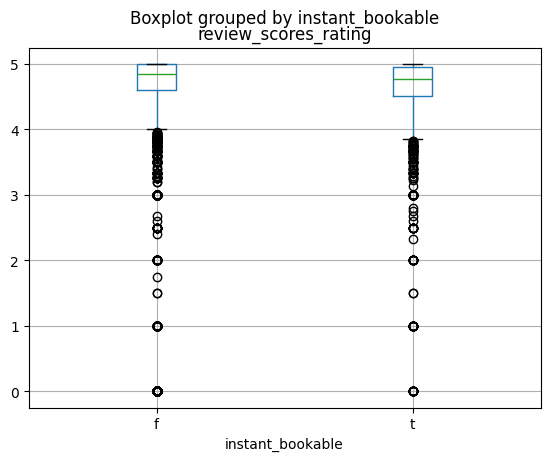

In [39]:
boxplot_var = ['host_response_time', 'host_is_superhost', 'host_verifications', 'host_has_profile_pic', 'host_identity_verified', 'neighbourhood_group_cleansed', 'room_type', 'has_availability', 'instant_bookable']
for var in boxplot_var:
    train_df.boxplot(column="review_scores_rating", by=var)

Empirical P(Y=1|X=x) for categorical  variables:

/usr/local/lib/python3.11/dist-packages/IPython/core/events.py:89: UserWarning: Glyph 20303 (\N{CJK UNIFIED IDEOGRAPH-4F4F}) missing from font(s) DejaVu Sans.
  func(*args, **kwargs)
/usr/local/lib/python3.11/dist-packages/IPython/core/events.py:89: UserWarning: Glyph 36807 (\N{CJK UNIFIED IDEOGRAPH-8FC7}) missing from font(s) DejaVu Sans.
  func(*args, **kwargs)
/usr/local/lib/python3.11/dist-packages/IPython/core/events.py:89: UserWarning: Glyph 33521 (\N{CJK UNIFIED IDEOGRAPH-82F1}) missing from font(s) DejaVu Sans.
  func(*args, **kwargs)
/usr/local/lib/python3.11/dist-packages/IPython/core/events.py:89: UserWarning: Glyph 22269 (\N{CJK UNIFIED IDEOGRAPH-56FD}) missing from font(s) DejaVu Sans.
  func(*args, **kwargs)
/usr/local/lib/python3.11/dist-packages/IPython/core/events.py:89: UserWarning: Glyph 20262 (\N{CJK UNIFIED IDEOGRAPH-4F26}) missing from font(s) DejaVu Sans.
  func(*args, **kwargs)
/usr/local/lib/python3.11/dist-packages/IPython/core/events.py:89: UserWarning: Glyph

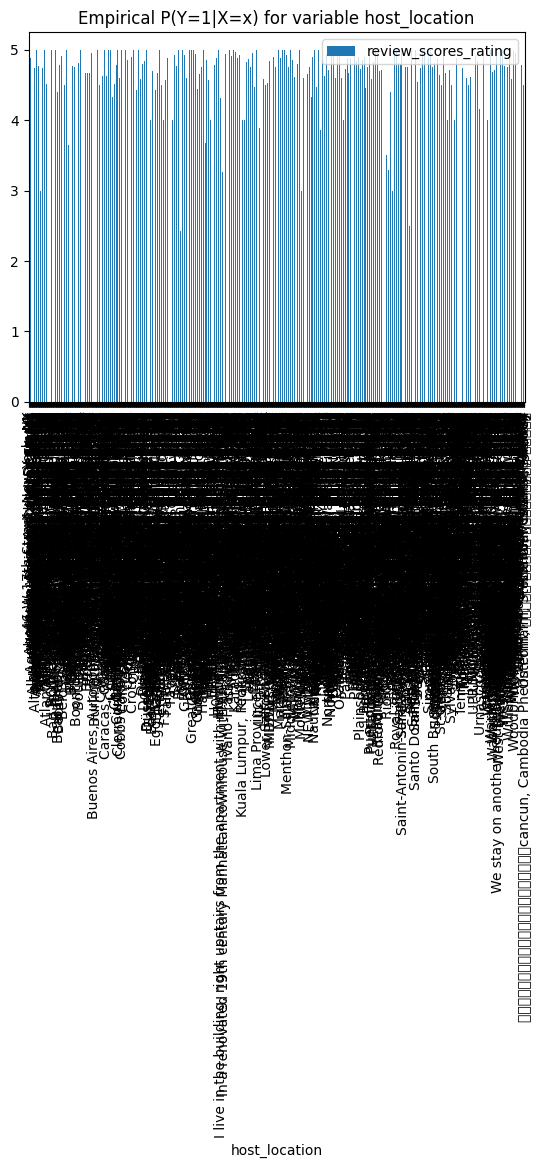

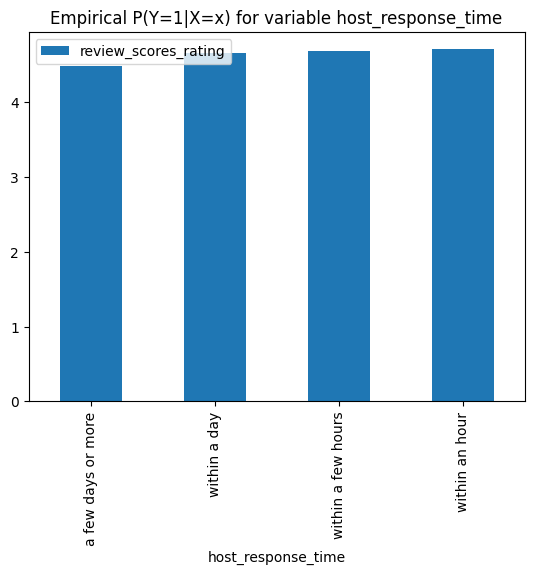

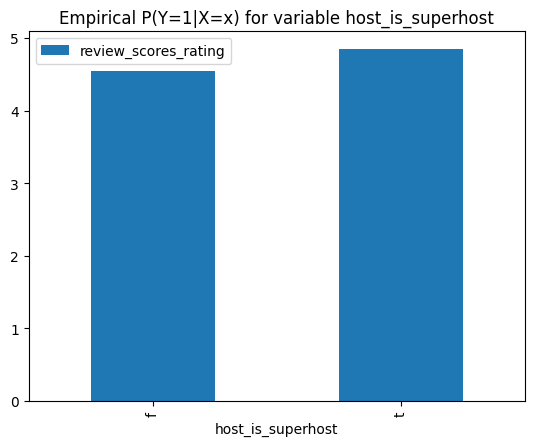

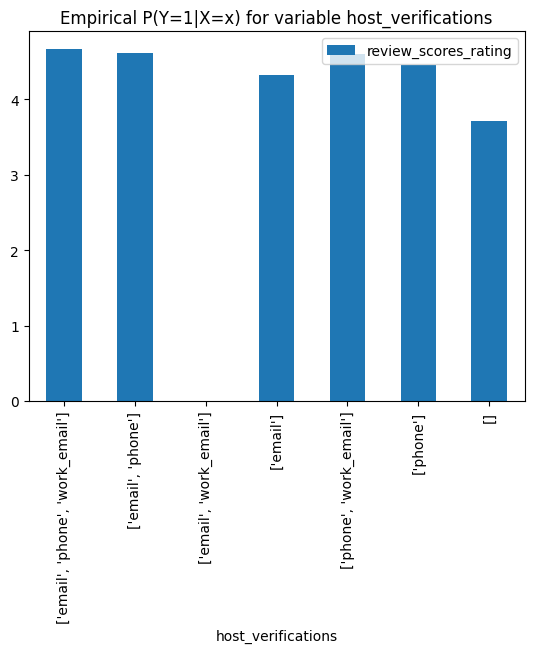

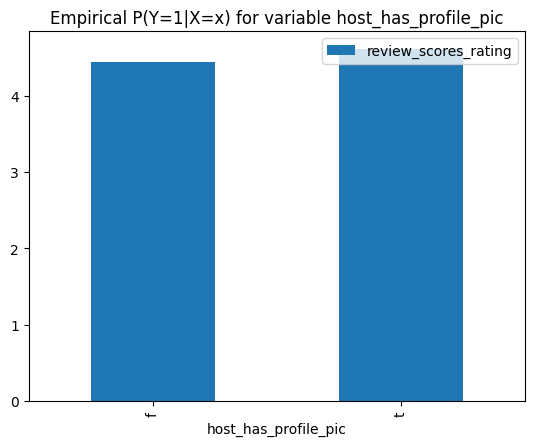

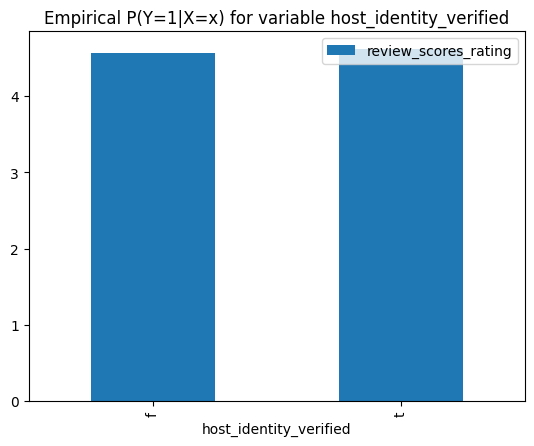

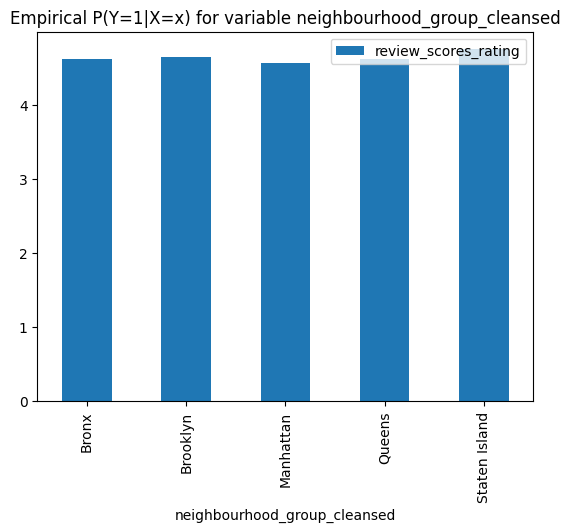

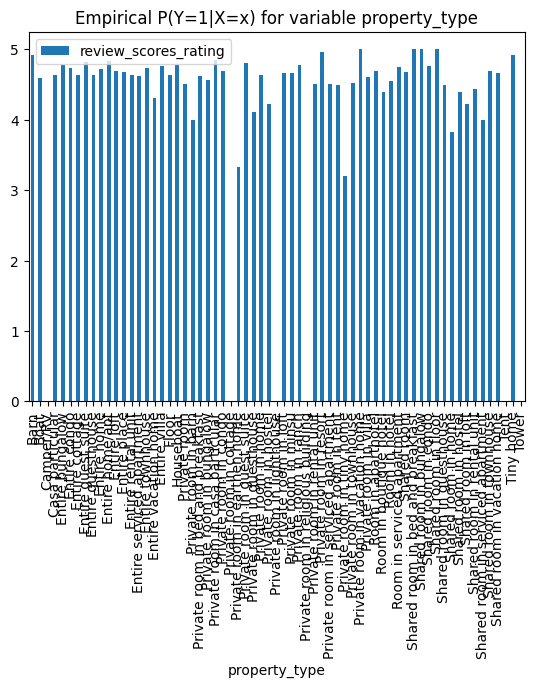

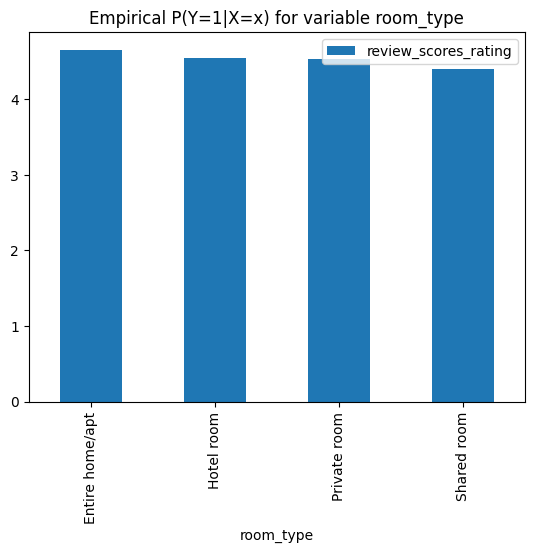

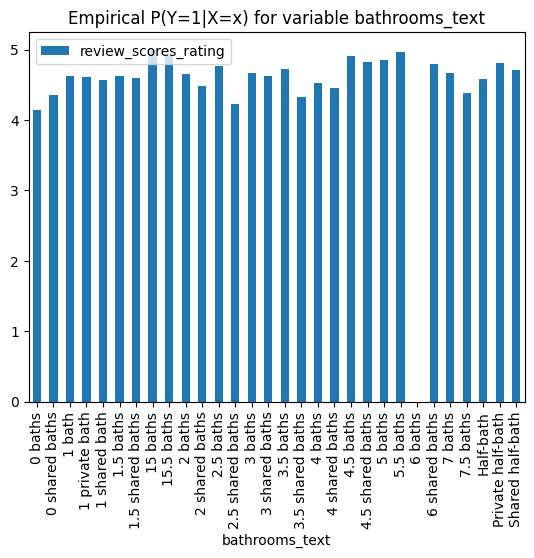

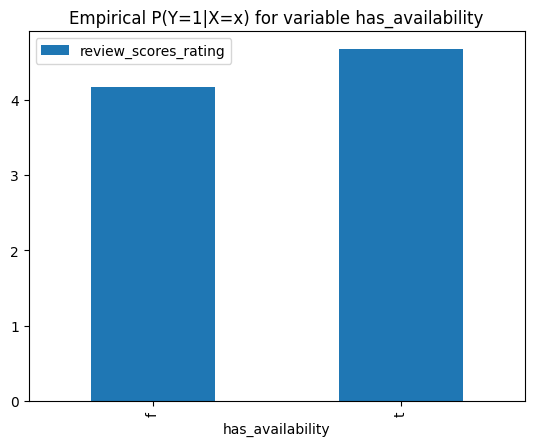

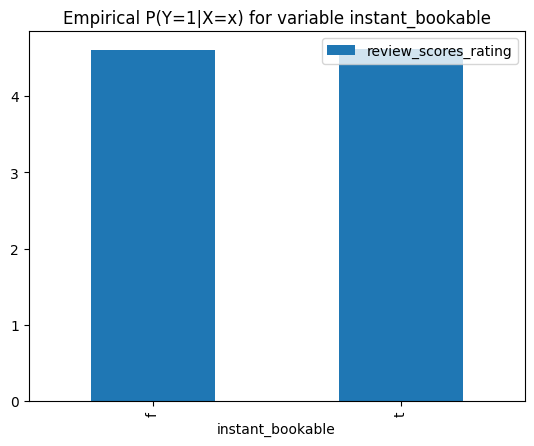

In [40]:
for var in cat_var:
    train_df.groupby(var).agg({"review_scores_rating": "mean"}).plot(kind="bar", title=f"Empirical P(Y=1|X=x) for variable {var}")

Elementary data analysis using pandas-profiling:

In [ ]:
#from pandas_profiling import ProfileReport
#profile = ProfileReport(train_df, title="Data report train set")
#profile.to_notebook_iframe()

<ipython-input-1-6a5a7dec4b59>:1: DeprecationWarning: `import pandas_profiling` is going to be deprecated by April 1st. Please use `import ydata_profiling` instead.
  from pandas_profiling import ProfileReport


NameError: name 'train_df' is not defined

Questions:
*   Can you explain the observed patterns for Monthly_CPI, Monthly_CCI and Euribor3m?
*   What do you think of the data quality?
*   We have used the "train dataset" for the data analysis? Should we have included the "validation set" and "test set" as well? If not: should we carry out additional analyses?
*   Which variables do you consider promising for modelling?


## 2. Feature engineering

Build datasets with dummies for categorical variables:

In [41]:
cat_var = ['host_response_time', 'host_is_superhost', 'host_verifications', 'host_has_profile_pic', 'host_identity_verified', 'neighbourhood_group_cleansed', 'room_type', 'has_availability', 'instant_bookable']
def add_dummies(df, cat_var):
    """Return new dataframe with dummy variables for specified categorical variables."""
    dummies_df = pd.DataFrame()
    for var in cat_var:
        aux = pd.get_dummies(df[[var]], prefix=f"ind_{var}", drop_first=False)
        dummies_df = pd.concat([dummies_df, aux], axis=1)
    return dummies_df

def build_X_y(df, num_var, cat_var, name_target):
    """Build datasets X, y for modelling."""
    num_df = df.copy()[num_var]
    dum_df = add_dummies(df, cat_var)
    X = pd.concat([num_df, dum_df], axis=1)
    y = df[name_target]
    return X, y

name_target = "review_scores_rating"
X_train, y_train =  build_X_y(train_df, num_var, cat_var, name_target)
X_validation, y_validation =  build_X_y(validation_df, num_var, cat_var, name_target)
X_test, y_test =  build_X_y(test_df, num_var, cat_var, name_target)
# ensure common columns
cols = list(set(X_train.columns).intersection(set(X_validation.columns)).intersection(set(X_test.columns)))
X_train = X_train[cols]
X_validation = X_validation[cols]
X_test = X_test[cols]

### 2.1 Logit model

Available features:

In [42]:
print(X_train.columns)

Index(['longitude', 'availability_30', 'review_scores_cleanliness',
       'ind_host_verifications_['phone', 'work_email']',
       'ind_host_identity_verified_f', 'ind_instant_bookable_f',
       'ind_instant_bookable_t', 'number_of_reviews_l30d',
       'host_response_rate', 'ind_neighbourhood_group_cleansed_Brooklyn',
       'review_scores_communication',
       'ind_neighbourhood_group_cleansed_Staten Island',
       'ind_host_identity_verified_t', 'beds', 'ind_room_type_Entire home/apt',
       'availability_60', 'accommodates', 'ind_host_verifications_['email']',
       'ind_room_type_Private room', 'ind_host_response_time_within a day',
       'ind_host_is_superhost_f', 'ind_neighbourhood_group_cleansed_Manhattan',
       'price', 'review_scores_checkin',
       'calculated_host_listings_count_shared_rooms', 'ind_has_availability_f',
       'availability_90', 'minimum_nights_avg_ntm', 'reviews_per_month',
       'latitude', 'availability_365',
       'ind_host_response_time_a fe

In [58]:
selected_features = ['longitude', 'review_scores_cleanliness',
       'host_response_rate', 'ind_neighbourhood_group_cleansed_Brooklyn',
       'review_scores_communication', 'beds', 'ind_room_type_Entire home/apt',
       'price', 'review_scores_checkin', 'calculated_host_listings_count_shared_rooms',
       'minimum_nights_avg_ntm', 'reviews_per_month', 'latitude', 'host_acceptance_rate',
       'number_of_reviews_ltm', 'number_of_reviews', 'calculated_host_listings_count',
       'bedrooms', 'ind_host_response_time_within an hour',
       'ind_host_has_profile_pic_t', 'ind_host_is_superhost_t',
       'calculated_host_listings_count_entire_homes', 'review_scores_accuracy',
       'review_scores_value', 'host_listings_count', 'maximum_nights_avg_ntm',
       'calculated_host_listings_count_private_rooms',
       'review_scores_location','ind_has_availability_t']

First we fit a linear regression using the Scikit-learn package (for machine learning):

In [59]:
y_train_clean = y_train.dropna()
X_train_clean = X_train.loc[y_train_clean.index]

imputer = SimpleImputer(strategy='mean')
X_train_imputed = imputer.fit_transform(X_train_clean[selected_features])

linreg = LinearRegression()
linreg.fit(X_train_imputed, y_train_clean)

LinearRegression()

Create DataFrame of estimated coefficients:

In [60]:
est_coef = pd.DataFrame(linreg.coef_, index=selected_features, columns=["estimated coefficient"])
est_coef.loc["intercept"] = linreg.intercept_
display(est_coef)

estimated coefficient
longitude                                              1.248697e-01
review_scores_cleanliness                              1.670694e-01
host_response_rate                                     1.095096e-03
ind_neighbourhood_group_cleansed_Brooklyn              1.118846e-02
review_scores_communication                            1.799422e-01
beds                                                   5.121025e-04
ind_room_type_Entire home/apt                          2.003982e-02
price                                                  3.454471e-05
review_scores_checkin                                  2.554977e-02
calculated_host_listings_count_shared_rooms            4.199266e-03
minimum_nights_avg_ntm                                -1.662675e-04
reviews_per_month                                      1.280554e-02
latitude                                              -3.081496e-02
host_acceptance_rate                                  -9.938847e-04
number_of_reviews_ltm                                 -1.257088e-03
number_of_reviews                                      2.204728e-04
calculated_host_listings_count                         1.490996e-03
bedrooms                                              -8.560165e-03
ind_host_response_time_within an hour                  2.580750e-02
ind_host_has_profile_pic_t                             6.604400e-02
ind_host_is_superhost_t                                4.741073e-02
calculated_host_listings_count_entire_homes           -9.500240e-04
review_scores_accuracy                                 2.532290e-01
review_scores_value                                    3.177886e-01
host_listings_count                                    8.481680e-06
maximum_nights_avg_ntm                                 5.140696e-11
calculated_host_listings_count_private_rooms          -1.238868e-03
review_scores_location                                 6.259821e-02
ind_has_availability_t                                 3.895088e-01
intercept                                              9.893491e+00

The estimated probabilities Y=1:

In [ ]:
probs_train = logit.predict_proba(X_train[selected_features])[:, 1]
plt.hist(probs_train)

In [ ]:
threshold = 0.5
y_pred_train = (logit.predict_proba(X_train[selected_features])[:, 1] > threshold)

In [ ]:
def plot_confusion_matrix(hat_y, y, target_values):
    matrix = confusion_matrix(y, hat_y)  # note that true label corresponds to first argument
    sns.heatmap(matrix.T, square=True, annot=True, fmt="d", cbar=False,
    xticklabels=target_values, yticklabels=target_values)
    plt.xlabel("true label")
    plt.ylabel("predicted label")
    accuracy = accuracy_score(y, hat_y, normalize=True, sample_weight=None)
    print("The accuracy is " + str(np.round(100*accuracy,1)) + "%")

plot_confusion_matrix(y_pred_train , y_train, [0, 1])

In [ ]:
def plot_roc(y, hat_prob_y):
    RocCurveDisplay.from_predictions(
        y,
        hat_prob_y,
        name="ROC curve",
        color="darkorange",
    )
    plt.plot([0, 1], [0, 1], "k--", label="chance level (AUC = 0.5)")
    plt.axis("square")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC curve")
    plt.legend()
    plt.show()


plot_roc(y_train, probs_train)

**Question**: evaluate performance on validation set

#### Decision tree

In [ ]:
clf = tree.DecisionTreeClassifier(max_depth=40)
model_tree = clf.fit(X_train, y_train)
ax = plt.figure(figsize=(25, 25))
tree.plot_tree(model_tree, max_depth=3, filled=True, fontsize=10)

In [ ]:
hat_target_train_tree = model_tree.predict(X_train)

plot_confusion_matrix(hat_target_train_tree, y_train, [0, 1])
plot_roc(y_train,  model_tree.predict_proba(X_train)[:, 1] )

**Question:** evaluate performance on the validation set

Question:  investigate impact of the 'max_depth' parameter.

### Random forest

In [ ]:
clf = RandomForestClassifier(n_estimators=250, random_state=123)
rf = clf.fit(X_train, y_train)

In [ ]:
hat_target_train_rf = rf.predict(X_train)

plot_confusion_matrix(hat_target_train_rf, y_train, [0, 1])
plot_roc(y_train,  rf.predict_proba(X_train)[:, 1] )

**Question:** investigate performance on the validation set.

**Question:** Consider the documentation of Scikit and investigate impact of max_depth.

### Xgboost

In [ ]:
xgb = xgb.XGBClassifier()
xgb.fit(X_train, y_train)

In [ ]:
hat_target_train_xgb = xgb.predict(X_train)

plot_confusion_matrix(hat_target_train_xgb, y_train, [0, 1])
plot_roc(y_train, xgb.predict_proba(X_train)[:, 1] )

**Question**: determine performance on validation set

In [ ]:
hat_target_train_xgb = xgb.predict(X_validation)

plot_confusion_matrix(hat_target_train_xgb, y_validation, [0, 1])
plot_roc(y_validation, xgb.predict_proba(X_validation)[:, 1] )